For this notebook you will need the file `notebooks\BERT\utils\count_class_py`. In this file all the function with there descriptions are available.

In [1]:
%load_ext autoreload
%autoreload 2

INF = 1e30

import os
from os import path


# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "AttentionGeometry":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.color_palette("flare", as_cmap=True)
from tqdm.notebook import tqdm

# from the environment
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from src.bert_model import BertNliRegu
from src.bert_data_module.esnli import ESNLIDataModule

# specific file for this notebook
from notebooks.BERT.utils.count_class import *

We will provide this work for our different datasets

- ESNLI

# E-SNLI

## FT -- version

In [2]:
# load data and model
data_dir = os.path.join(".cache_bert", "datasets", "EsnliDataSet")

dm = ESNLIDataModule(cache=data_dir,
                   batch_size = 4,
                   num_workers = 4,
                   nb_data = 999 # multiple of three for the consistency
                   )

dm.prepare_data()

dm.setup(stage="test")

test_dataset = dm.test_set
test_dataloader = dm.test_dataloader()

ckp = path.join(".cache_bert", "logs", "snli_igrida_trained", "0", "best.ckpt")
model = BertNliRegu.load_from_checkpoint(ckp)
model = model.to(DEVICE)
model = model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions

>> Searching the rep
>> rep found !
>> start the loop
>> all done !


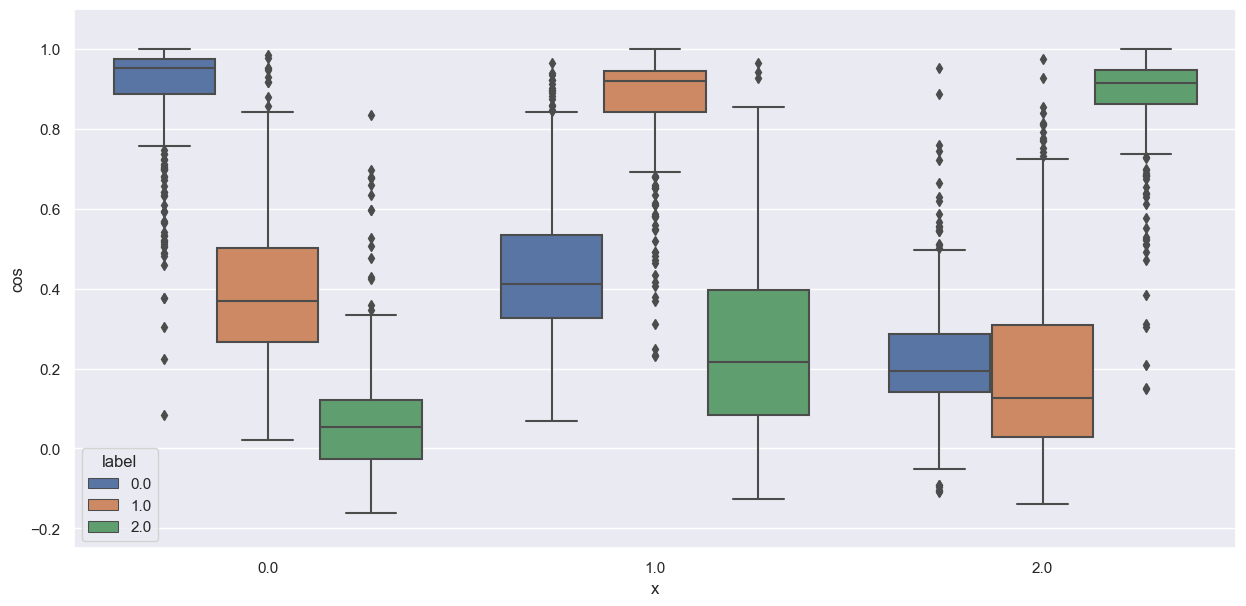

In [3]:
res, rep = main(model, dm, dm.nb_data, dm.batch_size)

x = np.concatenate((np.zeros(res.shape[0]), np.ones(res.shape[0]), 2*np.ones(res.shape[0])))
cos_values = np.concatenate((res["cos_class_0"].values, res["cos_class_1"].values, res["cos_class_2"].values))
labels = np.concatenate((res["label"], res["label"], res["label"]))
df = pd.DataFrame(
    {"x": x,
    "cos": cos_values,
    "label": labels,
    }
)
fig, axes = plt.subplots(1,1, figsize=(15, 7))
axes.set_ylim([-0.25, 1.1])
sns.boxplot(data=df, x="x", y="cos", hue="label", ax=axes)

plt.savefig(os.path.join(".cache_bert", "plots", "paper", "cone_class_esnli_ft.png"))

On peut voir ici un détachement. On a une séparation des classes qui est très flagrante

In [4]:
model = model.cpu()
del model
torch.cuda.empty_cache()

## PT -- version

In [5]:
# load data and model
data_dir = os.path.join(".cache_bert", "datasets", "EsnliDataSet")

dm = ESNLIDataModule(cache=data_dir,
                   batch_size = 4,
                   num_workers = 4,
                   nb_data = 999
                   )

dm.prepare_data()

dm.setup(stage="test")

test_dataset = dm.test_set
test_dataloader = dm.test_dataloader()

model = BertNliRegu()
model = model.to(DEVICE)
model = model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions

>> Re-use the rep
>> rep found !
>> start the loop
>> all done !


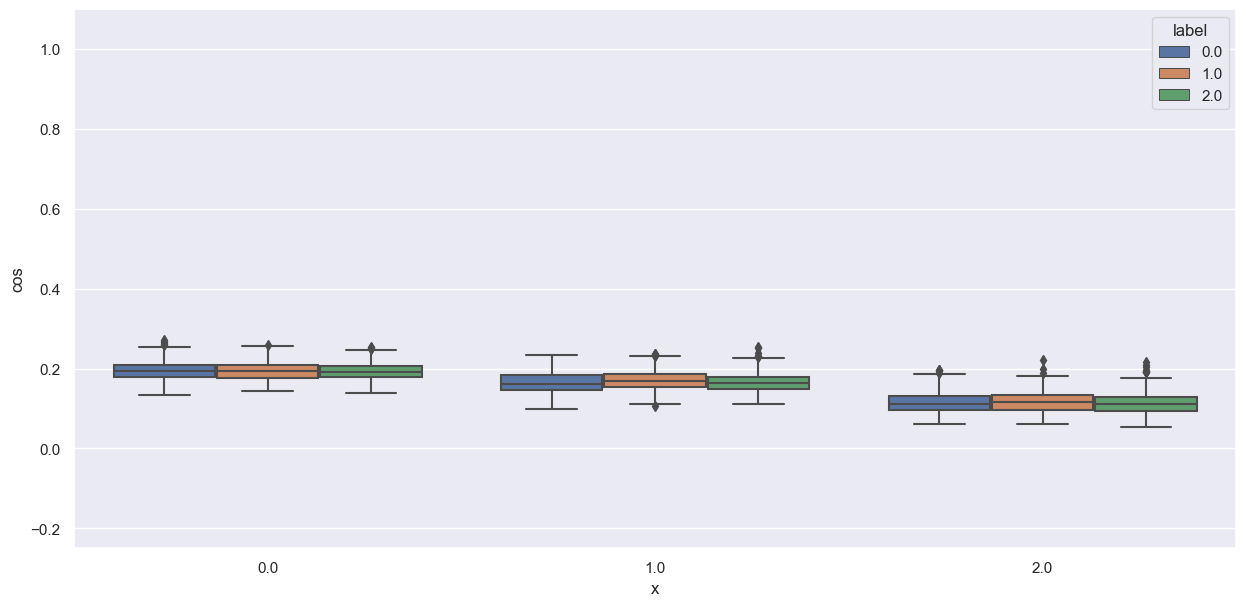

In [6]:
res, rep = main(model, dm, dm.nb_data, dm.batch_size, ft=False, representative=rep)

x = np.concatenate((np.zeros(res.shape[0]), np.ones(res.shape[0]), 2*np.ones(res.shape[0])))
cos_values = np.concatenate((res["cos_class_0"].values, res["cos_class_1"].values, res["cos_class_2"].values))
labels = np.concatenate((res["label"], res["label"], res["label"]))
df = pd.DataFrame(
    {"x": x,
    "cos": cos_values,
    "label": labels,
    }
)
fig, axes = plt.subplots(1,1, figsize=(15, 7))
axes.set_ylim([-0.25, 1.1])
sns.boxplot(data=df, x="x", y="cos", hue="label", ax=axes)

plt.savefig(os.path.join(".cache_bert", "plots", "paper", "cone_class_esnli_pt.png"))

Ici nous n'observons aucune séparation des classes en terme de direction.

In [7]:
model = model.cpu()
del model
torch.cuda.empty_cache()